<a href="https://colab.research.google.com/github/ANANTHMANOJ/phenmonia_eda/blob/master/IntrimProjectSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia

Pneumonia is one among the list of top-10 causes of death in some countries. Initally it requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR.

## Chest X-RAY basics and What Opacity Means

In the process of taking the image, an [X-ray](https://en.wikipedia.org/wiki/X-ray) passes through the body and reaches a detector on the other side. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb the X-rays and appear white in the image.
In short - 
* Black = Air 
* White = Bone 
* Grey = Tissue or Fluid

The left side of the subject is on the right side of the screen by convention. You can also see the small L at the top of the right corner. 
In a normal image we see the lungs as black, but they have different projections on them - mainly the rib cage bones, main airways, blood vessels and the heart.

Any area in the chest radiograph that is more white than it should be can term as ***Opacity*** 

Usually the lungs are full of air. When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. That's why areas of opacities are areas that are grey but should be more black. When we see them we understand that the lung tissue in that area is probably not healthy.

So in short, 


*   Balck Area in lungs  --> Healthy
*   white / Grey in the lungs  --> Unhealthy or Have Opacity

## Problem Faced

There are some problems that are faced in hospitals. Some of them are jotted bellow:
* Identifing the pneumonia needs specialized and trained doctors, as to find the minute spots in X-Rays and other symtoms.
* And  examining the X-Rays would take time for any such doctors.
* Lack of Specialized doctors in remote places of the world makes it difficult to identify such diseases.

So, how can we over come this problem will be over concern, which drives to our project identification of Pneumonia.

##  Objective

### Our objective is to build a model which takes a CXR image as input and attempts to find potentially infected-area and predicts the position of box/boxes bounding the infected area.

#### How would this project  worthy?

* Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. 
* Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
* Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

#### Plans to achieve the objective

- We have understood our goal to achieve, i.e to build a pneumonia detection system, to locate the position of inflammation in an image.
- The dataset has been collected to explore the various scenarios of pneumonia cases in patient.
- Exploring the data, feature extracting the data required and preparing the data for the model.
- Identifing the suitable model for our problem, finding the accuracy of the model and fine tuning the model to give best results.

It is a supervised-learning problem

## About Data

#### Description of the Pneumonia Dataset

Data consists of following files :
1.   stage_2_train_images
2.   stage_2_test_images
3.   stage_2_detailed_class_info.csv - contains information about the positive and negative classes in the training set
4.   stage_2_train_labels.csv - contains information about bounding boxes along with train dataset images

The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: `x-min y-min width height`

There is also a binary target column, `Target`, indicating pneumonic or non-pneumonic.

There may be multiple rows per `patientId`.

In [1]:
!pip3 install pydicom

     |████████████████████████████████| 35.5MB 1.3MB/s 


In [2]:
import pandas as pd
import numpy as np
import pydicom as dicom
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/phemonia_capstone_eda/data'
os.chdir(path)

Mounted at /content/drive


In [4]:
# path of data folder
data_path = Path('/content/drive/My Drive/phemonia_capstone_eda/data')

## Class info

In [5]:
class_info_path = data_path / 'stage_2_detailed_class_info.csv'

In [6]:
class_info = pd.read_csv(class_info_path)

In [7]:
class_info.shape

(30227, 2)

- Total 30227 records

In [8]:
class_info.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


In [9]:
# Total patients
class_info['patientId'].nunique()

26684

- Total patients - 26684

### A patient may fall into any of the 3 categories:
#### label-1
- having Pneumonia, 

##### label-0
- not having Pneumonia and normal
- not having Pneumonia and not-normal/no-lung-opacity

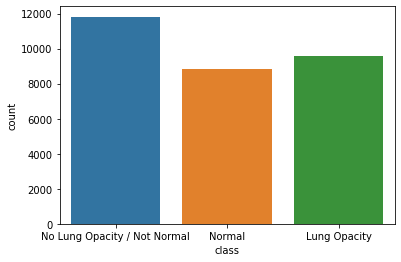

In [10]:
sns.countplot(class_info['class']);

- Not Normal ~ 12000 
- Normal ~ 9000
- Lung Opacity ~ 9500

- Class ditribution is imbalanced - having more records in  class-0 (non-pneumonia) than class-1 (pneumonia)

## Labels data

In [11]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [12]:
labels = pd.read_csv(labels_path)

In [13]:
labels.shape

(30227, 6)

- Total records = 30227

In [14]:
labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


- Total 6 columns
- 1 for id
- 4 for position of box
- 1 for Target variable

In [15]:
labels['patientId'].nunique()

26684

- Total patients = 26684
- A patient may have multiple records corresponding to each infected area.

In [16]:
n_infected_area = labels.groupby('patientId').sum()['Target']

#### Number of Healthy patients

In [17]:
(n_infected_area==0).sum()

20672

#### Number of infected patients

In [18]:
(n_infected_area!=0).sum()

6012

In [19]:
'Infected Patients - {0:.1f} %'.format(6012/20672*100)

'Infected Patients - 29.1 %'

#### Class distribution

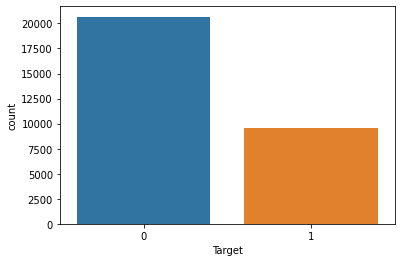

In [20]:
sns.countplot(labels['Target']);

In [21]:
np.bincount(labels['Target'])

array([20672,  9555])

- class-0 (not infected) -- 20672
- class-1 (infected)     -- 9555

#### Here, no. of infected patients is 6012 while number of records in class-1 is 9555, the difference is because  a patient may have more than 1 infected area and thus having more than 1 record per patient 

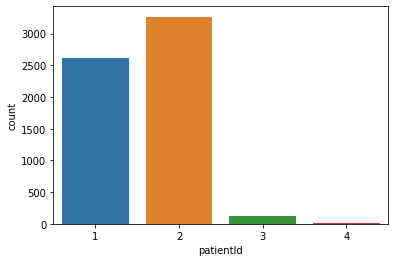

In [22]:
# this plot depicts the distribution of number-of-infected-area among infected patients.
sns.countplot(labels[labels['Target']==1]['patientId'].value_counts());

- Almost all people have 1 or 2 infected areas
- Very few people with 3 or 4 infected areas

Scatter plot for the center of the bounding-box points in the plane x0y.   The centers of the rectangles are the points $$x_c = x + \frac{width}{2}$$ and $$y_c = y + \frac{height}{2}$$

We will show a sample of center points superposed with the corresponding sample of the rectangles.
The rectangles are created using the method described in Kevin's Kernel <a href="#4">[1]</a>


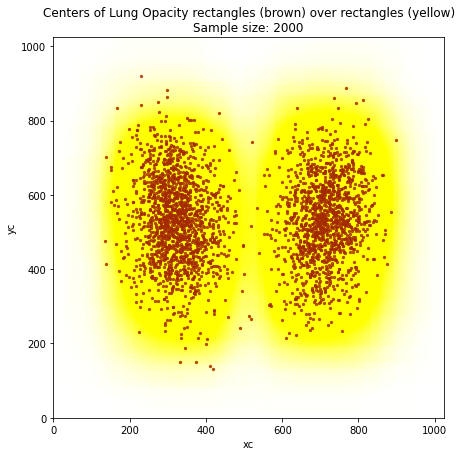

In [23]:
target1 = labels[labels['Target']==1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
target_sample = target1.sample(3000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000')
target_sample.plot.scatter(x='xc', y='yc', xlim=(0, 1024), ylim=(0, 1024), ax=ax, alpha=0.8, marker=".", color='brown')
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

##### For class-0 there are obviously no box coordinates as they are non-pneumonic so all must be nan

In [24]:
labels[labels['Target'] == 0].isna().all()

patientId    False
x             True
y             True
width         True
height        True
Target       False
dtype: bool

###### For class-1 let's check for any nan values

In [25]:
labels[labels['Target'] == 1].isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

The `labels` and `class_info` datasets do not share a joining keyword column, but the rows are listed in the exact same order, therefore we can combine the two dataframes by concatenating their columns.

## Distribution of position of bounding-box

In [26]:
# df --> all positive records
df = labels[labels['Target'] == 1]
df.head(2)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


#### 1. Scatter plot

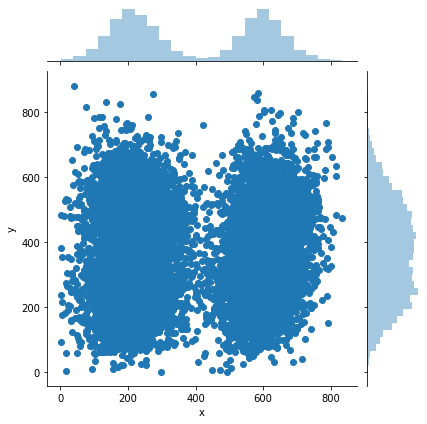

In [27]:
sns.jointplot(x = 'x', y = 'y', data = df, kind = 'scatter');

#### 2. Box plot

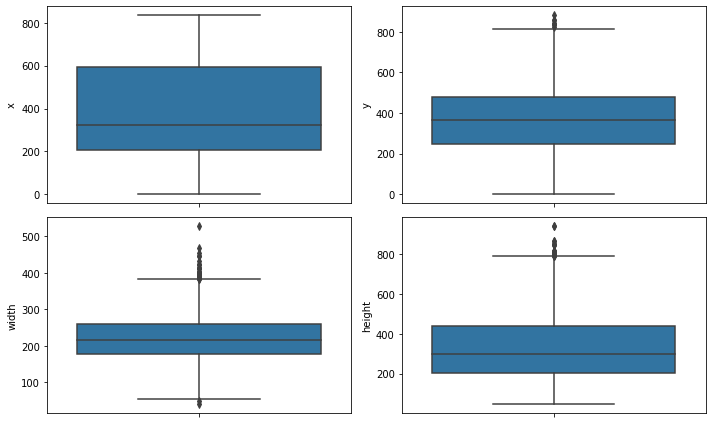

In [28]:
n_columns = 2
n_rows = 2
_, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 3 * n_rows))
for i, c in enumerate(df.columns[1:-1]):
    sns.boxplot(y = c, data = df, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

## Image data

In [29]:
images_path = data_path / 'stage_2_train_images'

In [32]:
# Total number of patients
n_patient = len(os.listdir(images_path))
n_patient

26684

In [33]:
filename = os.listdir(images_path)[0]

file = dicom.dcmread(images_path / filename)

In [34]:
file.pixel_array.shape

(1024, 1024)

- Given CXR is 1024x1024 dimensional 2-D image. We might perhaps need to reshape the data appropriately.

In [35]:
file.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

### Above are the attributes of which only a handful are available to us, namely, PatientAge, PatientSex, ViewPosition

In [36]:
def get_attrib(filename):
    '''Returns: tuple, containing age and gender corresponding to filename'''
    id = filename.split('.')[0]
    file = dicom.dcmread(images_path / filename)
    return (id, file.PatientAge, file.PatientSex, file.ViewPosition)

In [37]:
# Using python built-in Multi-Processing API to load age and gender
'''with ProcessPoolExecutor() as executor:
    a = list(executor.map(get_attrib, os.listdir(images_path)))'''

'with ProcessPoolExecutor() as executor:\n    a = list(executor.map(get_attrib, os.listdir(images_path)))'

In [38]:
#attrib = pd.DataFrame(a, columns=['id', 'age', 'gender', 'view-position'])

In [39]:
#attrib.head(3)

In [40]:
#attrib.info()

##### age

In [41]:
path='/content/drive/My Drive/phemonia_capstone_eda'
os.chdir(path)

In [42]:
#attrib.to_csv('trained_attrib.csv')
attrib = pd.read_csv('trained_attrib.csv')
attrib

,Unnamed: 0,id,age,gender,view-position
0,0,f79e5a75-5e15-431a-9ba3-de64c1724b65,59,M,PA
1,1,f79fa94e-8886-425c-95d4-81abfea92aee,43,F,PA
2,2,f79fc759-fde0-4e2e-8951-26ac8af5ef89,45,F,AP
3,3,f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9,52,M,PA
4,4,f7a172fc-a34f-4155-806d-7b0afe2a6156,26,M,AP
...,...,...,...,...,...
26679,26679,094977f5-89e2-4f48-9c9f-5954aac94d59,52,M,AP
26680,26680,0949d712-9d3c-424a-99b5-423a598d8b97,64,M,AP
26681,26681,0949dfc4-7613-432c-8d16-4cf0aa5b15bb,40,M,PA
26682,26682,094eed38-9c5b-4042-936d-344ccec4c3cc,65,F,AP


In [43]:
path='/content/drive/My Drive/phemonia_capstone_eda/data'
os.chdir(path)

In [44]:
attrib['age'] = attrib['age'].astype('int8')

In [45]:
attrib.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,26684.0,13341.500000,7703.151628,0.0,6670.75,13341.5,20012.25,26683.0
age,26684.0,46.982049,16.877806,-108.0,34.00,49.0,59.00,92.0


In [46]:
(attrib['age']<0).sum()

5

- 5 negative

##### gender

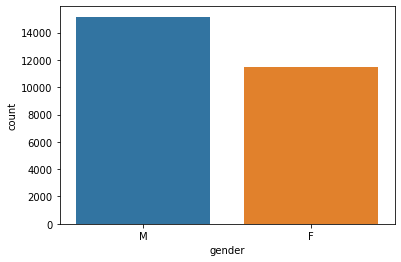

In [47]:
sns.countplot(attrib['gender']);

##### view-position

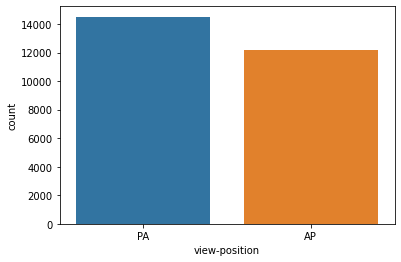

In [48]:
sns.countplot(attrib['view-position']);

#### Plotting CXR images

In [74]:
box= np.zeros((256,256))
box

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
def plot_image(filename):
    'Display x-ray image with bounding boxes (if applicable) correspondin to filename'
    
    # reading dicom file
    file = dicom.dcmread(images_path / filename)
    
    # id is just 'filename' with it's extension(dcm) having removed
    id = filename.split('.')[0]  
    
    # All records corresponding to a particular id
    # Each record contains Target-variable value (1/0) and box-position information
    records = labels[labels['patientId']==id]
    
    fig, ax = plt.subplots(1)
    
    # Whether this patient (this id) is pneumonic or not
    if (len(records)==1 and records['Target'].values[0]==0):
        has_pneumonia = False
    else:
        has_pneumonia = True
    box= np.zeros((256,256))
    # If pneumonic then draw the bbox as well else only plot the image
    if has_pneumonia:
        # Iterating over all the records to get bbox
        for i, s in records.iloc[:, 1:5].iterrows():
            bbox = Rectangle((s['x'], s['y']), s['width'], s['height'], color='blue',
                             fill=False)
            ax.add_patch(bbox)
        am = ax.imshow(file.pixel_array, cmap='gray')
        print(am)
    else:
        ax.imshow(file.pixel_array, cmap='gray')
    
    # which class (of the total 3 classes) does this id belong to
    c = class_info[class_info['patientId'] == id]['class'].values[0]
    ax.set_xlabel(c)

AxesImage(54,36;334.8x217.44)


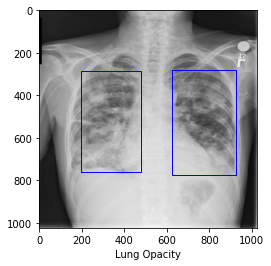

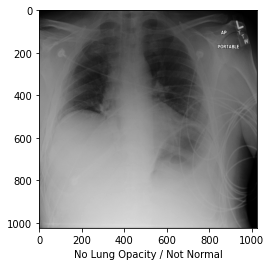

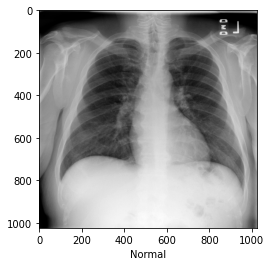

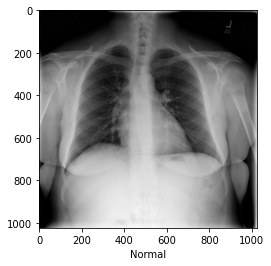

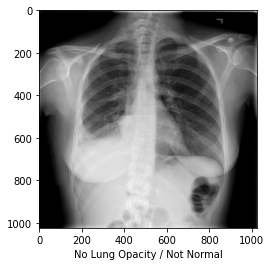

In [82]:
# ploting 5 random scans
for _ in range(5):
    n = np.random.randint(n_patient)
    filename = os.listdir(images_path)[n]
    plot_image(filename)

- This is a object-detection problem, where the 'object' is potentially-infected-area.
- Convolutional Neural Networks have proved to be very successful in object-detection problems. So we are going to build a model based on CNN
- We are going to employ a technique called Transfer Learning, where a pre-trained model is used as a starting point and fine-tuned with a different dataset.

- Data needs to pre-processed according to the chosen algorithm

## Prospective algorithms

- Mask R-CNN is an object instance segmentation and thus can also be used for object-dection. https://github.com/matterport/Mask_RCNN
- DeepLab https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
- CheXNet algorithm  a 121-layer deep 2D Convolutional Neural Network
- To build a model from scratch, with Dense layers of conv2d(),normalization, dropouts and maxpools as set of layers and experimenting with various parameters

Some other algorithms that we can make use of:
- VGG-19 is a convolutional neural network that is 19 layers deep.
- MobileNets are small, low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases.

In [51]:
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3171.1517874300.465651
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [52]:
array = file.pixel_array

In [53]:
filename = os.listdir(images_path)
pics = []
target_list_box = []
target_a_box = []
j=0
for i in range(n_patient):
  list_boxes=[]
  array_boxes=[]
  file = dicom.dcmread(images_path / filename[i]) 
  img = cv2.resize(file.pixel_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  pics.append(img)   
# id is just 'filename' with it's extension(dcm) having removed
  id = filename[i].split('.')[0]    
  # All records corresponding to a particular id
    # Each record contains Target-variable value (1/0) and box-position information
  records = labels[labels['patientId']==id]
  if (len(records)==1 and records['Target'].values[0]==0):
    has_pneumonia = False
  else:
    has_pneumonia = True
  if has_pneumonia:
  # Iterating over all the records to get bbox
    for i, s in records.iloc[:, 1:5].iterrows():
      list_boxes.append([s['x']/4, s['y']/4, s['width']/4, s['height']/4,1])
      array_boxes.append(np.array([s['x']/4, s['y']/4, s['width']/4, s['height']/4,1]))

  else:
    list_boxes.append(['','','','',0])
    array_boxes.append(np.array(['','','','',0]))
  target_list_box.append(list_boxes)
  target_a_box.append(array_boxes)

    # which class (of the total 3 classes) does this id belong to
  print(j)
  j+=1

Streaming output truncated to the last 5000 lines.
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
2

In [ ]:
s

In [ ]:
path='/content/drive/My Drive/phemonia_capstone_eda'
os.chdir(path)

In [ ]:
'''import pickle
with open('xray_resized.txt',"wb") as fp:
  pickle.dump(pics,fp)
with open('boxes_resized.txt',"wb") as fp:
  pickle.dump(target_box,fp)'''

In [ ]:
import pickle
with open('xray_resized.txt',"rb") as fp:
  loaded_pic = pickle.load(fp)
with open('boxes_resized.txt',"rb") as fp:
  loaded_boxes = pickle.load(fp)

In [ ]:
len(loaded_boxes)

In [ ]:
loaded_pic

In [ ]:
path='/content/drive/My Drive/phemonia_capstone_eda/data'
os.chdir(path)

In [ ]:
len(labels)

In [ ]:
#pics

In [ ]:
import cv2

boxy = cv2.resize(256, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [ ]:
boxy

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [55]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=1 ,padding= 'same',activation='relu',input_shape=(256,256,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding= 'same'))

model.add(Conv2D(64,(3,3),strides=1 ,padding= 'same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2),strides=2,padding= 'same'))

model.add(Conv2D(64,(3,3),strides=1 ,padding= 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding= 'same'))

model.add(Conv2D(128,(3,3),strides=1 ,padding= 'same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2),strides=2,padding= 'same'))

model.add(Conv2D(256,(3,3),strides=1 ,padding= 'same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding= 'same'))

model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5,activation='sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [56]:
reduced_lr = ReduceLROnPlateau( monitor= 'val_accuracy',patience= 2, verbose= 1, factor= 0.3, min_lr= 0.000001)

In [ ]:
l_p = np.array(pics)

In [ ]:
l_b = np.array(target_box)

In [65]:
model.fit(x= pics, y= an,batch_size=32, epochs=5 , callbacks=[reduced_lr])

ValueError: ignored

In [ ]:
l_b

In [60]:
ak=np.asarray(target_a_box)

In [63]:
an = np.asarray(ak)

In [64]:
an

array([list([array(['', '', '', '', '0'], dtype='<U1')]),
       list([array(['', '', '', '', '0'], dtype='<U1')]),
       list([array([153.25,  60.25,  42.25, 119.75,   1.  ]), array([ 69.  ,  62.  ,  42.  , 119.25,   1.  ])]),
       ..., list([array(['', '', '', '', '0'], dtype='<U1')]),
       list([array([ 30.5,  87.5,  75. , 112.5,   1. ]), array([136.  ,  86.5 ,  74.25, 130.  ,   1.  ])]),
       list([array(['', '', '', '', '0'], dtype='<U1')])], dtype=object)